In [1]:
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 34.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.11.0.86
    Uninstalling opencv-python-headless-4.11.0.86:
      Successfully uninstalled opencv-python-headless-4.11.0.86
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sigstore 3.6.1 requires rich~=13.0, but you have rich 14.0.0 which is incompatible.
datasets 3.5.0 requires fsspec[http]<=

In [2]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

2025-05-31 17:00:50.982250: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748710851.359057      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748710851.473422      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
rf = Roboflow(api_key="jblXI5MTWDuIfBMWytfI")
project = rf.workspace("tooth-instance-segmentation-ks7aj").project("tooth-instance-segmentation")
dataset = project.version(2).download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Tooth-instance-segmentation-2 in yolov11:: 100%|██████████| 8722/8722 [00:02<00:00, 3359.97it/s]


In [4]:
# Check files in main path
print(os.listdir("/kaggle/working"))


['.virtual_documents', 'Tooth-instance-segmentation-2']


In [8]:
dataset_dir = "/kaggle/working/Tooth-instance-segmentation-1"
print(os.listdir(dataset_dir))

['data.yaml', 'test', 'train', 'valid', 'README.roboflow.txt', 'README.dataset.txt']


In [9]:
# Show train, val, و test Files
train_dir = "/kaggle/working/Tooth-instance-segmentation-1/train"
val_dir = "/kaggle/working/Tooth-instance-segmentation-1/valid"
test_dir = "/kaggle/working/Tooth-instance-segmentation-1/test"

print("Train files:", os.listdir(train_dir))
print("Val files:", os.listdir(val_dir))
print("Test files:", os.listdir(test_dir))


Train files: ['images', 'labels']
Val files: ['images', 'labels']
Test files: ['images', 'labels']


In [10]:
def check_image_format(image_dir):
    for filename in os.listdir(image_dir):
        file_path = os.path.join(image_dir, filename)
        if os.path.isfile(file_path):
            try:
                img = Image.open(file_path)
                img.verify()  # check if photo valid
            except (IOError, SyntaxError) as e:
                print(f"Error with image {filename}: {e}")

# Select photos only
train_images = "/kaggle/working/Tooth-instance-segmentation-1/train/images"
val_images = "/kaggle/working/Tooth-instance-segmentation-1/valid/images"
test_images = "/kaggle/working/Tooth-instance-segmentation-1/test/images"

check_image_format(train_images)
check_image_format(val_images)
check_image_format(test_images)


In [11]:
def check_missing_labels(image_dir, label_dir):
    missing_labels = []
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            label_file = os.path.splitext(filename)[0] + ".txt"
            if not os.path.exists(os.path.join(label_dir, label_file)):
                missing_labels.append(filename)
    return missing_labels

train_labels = "/kaggle/working/Tooth-instance-segmentation-1/train/labels"
val_labels = "/kaggle/working/Tooth-instance-segmentation-1/valid/labels"
test_labels = "/kaggle/working/Tooth-instance-segmentation-1/test/labels"

missing_train = check_missing_labels(train_images, train_labels)
missing_val = check_missing_labels(val_images, val_labels)
missing_test = check_missing_labels(test_images, test_labels)

print("Missing labels in train:", missing_train)
print("Missing labels in val:", missing_val)
print("Missing labels in test:", missing_test)


Missing labels in train: []
Missing labels in val: []
Missing labels in test: []


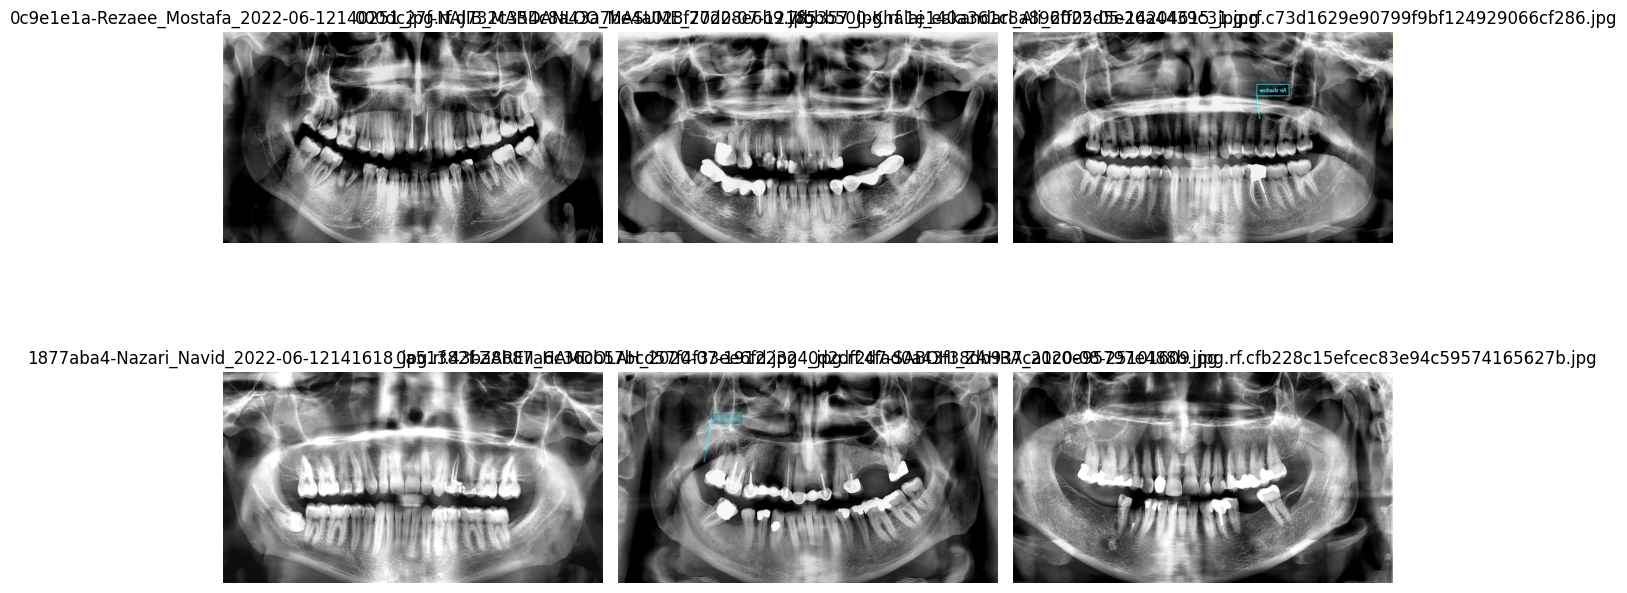

In [10]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# training images path
images_path = "/kaggle/working/Tooth-instance-segmentation-2/train/images"

# random image
num_images = 6
image_files = random.sample(os.listdir(images_path), num_images)

# show images
plt.figure(figsize=(12, 8))
for i, image_file in enumerate(image_files):
    img = mpimg.imread(os.path.join(images_path, image_file))
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(image_file)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [11]:
def quick_validate_label_format(label_dir, max_files=10):
    checked = 0
    for filename in os.listdir(label_dir):
        if filename.endswith('.txt'):
            with open(os.path.join(label_dir, filename), 'r') as f:
                for line_num, line in enumerate(f, 1):
                    parts = line.strip().split()
                    if len(parts) != 5:
                        print(f"{filename}, line {line_num}: wrong number of elements => {parts}")
                        break
                    try:
                        class_id = int(parts[0])
                        coords = [float(x) for x in parts[1:]]
                        if not all(0 <= x <= 1 for x in coords):
                            print(f"{filename}, line {line_num}: coordinates out of range => {coords}")
                            break
                    except ValueError:
                        print(f"{filename}, line {line_num}: invalid number format => {parts}")
                        break
            checked += 1
            if checked >= max_files:
                break

print("Train labels:")
quick_validate_label_format(train_labels)

print("\nVal labels:")
quick_validate_label_format(val_labels)

print("\nTest labels:")
quick_validate_label_format(test_labels)


Train labels:
782004e1-Barghabani_Zahra_33y_08062021_162807_jpg.rf.6d01f45c6a0f945b8b29631e523d13bb.txt, line 1: wrong number of elements => ['0', '0.6453757361111111', '0.5223365179999999', '0.6468851588888889', '0.508464968', '0.6418557127777778', '0.493527601', '0.6373286216666667', '0.49566242', '0.6358197877777777', '0.506332272', '0.639843345', '0.520201699', '0.6453757361111111', '0.5223365179999999']
96_png_jpg.rf.cae2c9023b4c1a35da8af138e95ac056.txt, line 1: wrong number of elements => ['2', '0.6827617977777778', '0.487651734', '0.689857865', '0.49041040500000005', '0.6926966294444445', '0.48948988400000004', '0.6941157305555555', '0.48948988400000004', '0.6980191011111111', '0.49041040500000005', '0.6994382022222222', '0.486731214', '0.6994382022222222', '0.475696532', '0.6983735955555556', '0.460982659', '0.6973095505555555', '0.455465318', '0.6955353933333334', '0.453625723', '0.6941157305555555', '0.454544798', '0.6912775283333333', '0.455465318', '0.68879382', '0.45730491

In [12]:
print("Train Images:", len(os.listdir(train_images)))
print("Train Labels:", len(os.listdir(train_labels)))

print("Val Images:", len(os.listdir(val_images)))
print("Val Labels:", len(os.listdir(val_labels)))

print("Test Images:", len(os.listdir(test_images)))
print("Test Labels:", len(os.listdir(test_labels)))

Train Images: 3655
Train Labels: 3655
Val Images: 400
Val Labels: 400
Test Images: 300
Test Labels: 300


In [5]:
!pip install ultralytics --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 18.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found exi

Number of instances per class in train set:
Caries: 14619
Filling: 24960
Root Canal Obturation: 16575
Crown - bridge: 4791
Post-screw: 2276
Implant: 721


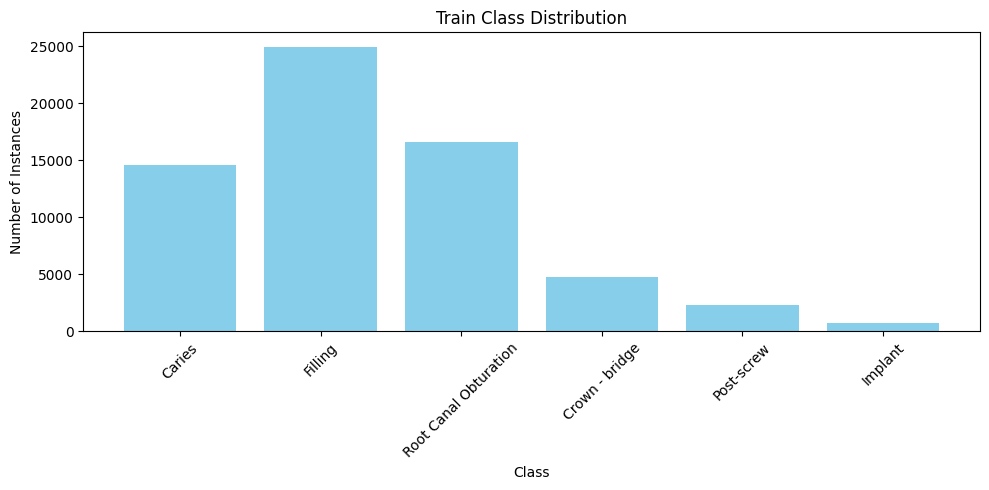

In [14]:
import os
from collections import Counter
import matplotlib.pyplot as plt

def count_labels(label_dir, class_names):
    class_counts = Counter()

    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():  # تأكد إن السطر مش فاضي
                    cls_id = int(line.strip().split()[0])
                    class_counts[cls_id] += 1

    # Convert class IDs to class names
    result = {class_names[k]: v for k, v in class_counts.items()}
    return result

# Define path to labels in Tooth-instance-segmentation
train_labels = "/kaggle/working/Tooth-instance-segmentation-2/train/labels"

# Define class names based on order in Roboflow config
class_names = ['Caries', 'Crown - bridge', 'Filling', 'Implant', 'Post-screw', 'Root Canal Obturation']

# Analyze label distribution
train_class_distribution = count_labels(train_labels, class_names)

# Print results
print("Number of instances per class in train set:")
for k, v in train_class_distribution.items():
    print(f"{k}: {v}")

# Plot
plt.figure(figsize=(10, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.tight_layout()
plt.show()


In [ ]:
# Define label paths
val_labels = "/kaggle/working/Tooth-instance-segmentation-2/valid/labels"
test_labels = "/kaggle/working/Tooth-instance-segmentation-2/test/labels"

# Class distribution in the validation set
val_class_distribution = count_labels(val_labels, class_names)
print("\nNumber of instances per class in validation set:")
for k, v in val_class_distribution.items():
    print(f"{k}: {v}")

# Class distribution in the test set
test_class_distribution = count_labels(test_labels, class_names)
print("\nNumber of instances per class in test set:")
for k, v in test_class_distribution.items():
    print(f"{k}: {v}")



Number of instances per class in validation set:
Filling: 2617
Caries: 1732
Post-screw: 297
Root Canal Obturation: 1816
Crown - bridge: 563
Implant: 98

Number of instances per class in test set:
Crown - bridge: 522
Filling: 2082
Root Canal Obturation: 1315
Post-screw: 105
Caries: 557
Implant: 73


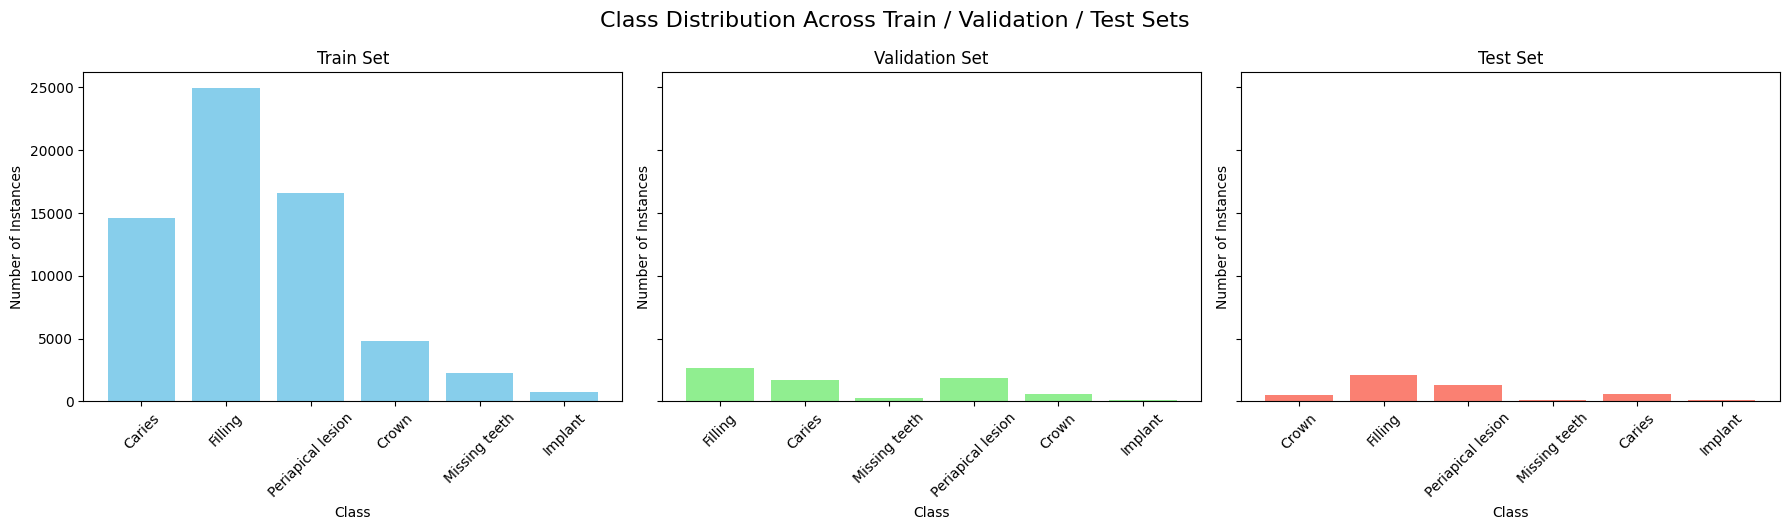

In [16]:
import os
from collections import Counter
import matplotlib.pyplot as plt

def count_labels(label_dir, class_names):
    class_counts = Counter()
    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():
                    cls_id = int(line.strip().split()[0])
                    class_counts[cls_id] += 1
    result = {class_names[k]: v for k, v in class_counts.items()}
    return result

# Define class names
class_names = ['Caries', 'Crown', 'Filling', 'Implant', 'Missing teeth',
               'Periapical lesion', 'Root Piece', 'Root canal obturation', 'Crown - bridge']

# Define label paths
train_labels = "/kaggle/working/Tooth-instance-segmentation-2/train/labels"
val_labels = "/kaggle/working/Tooth-instance-segmentation-2/valid/labels"
test_labels = "/kaggle/working/Tooth-instance-segmentation-2/test/labels"

# Count labels
train_dist = count_labels(train_labels, class_names)
val_dist = count_labels(val_labels, class_names)
test_dist = count_labels(test_labels, class_names)

# Prepare subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Train
axs[0].bar(train_dist.keys(), train_dist.values(), color='skyblue')
axs[0].set_title("Train Set")
axs[0].tick_params(axis='x', rotation=45)

# Validation
axs[1].bar(val_dist.keys(), val_dist.values(), color='lightgreen')
axs[1].set_title("Validation Set")
axs[1].tick_params(axis='x', rotation=45)

# Test
axs[2].bar(test_dist.keys(), test_dist.values(), color='salmon')
axs[2].set_title("Test Set")
axs[2].tick_params(axis='x', rotation=45)

# Common labels
for ax in axs:
    ax.set_xlabel("Class")
    ax.set_ylabel("Number of Instances")

plt.tight_layout()
plt.suptitle("Class Distribution Across Train / Validation / Test Sets", fontsize=16, y=1.05)
plt.show()


# Update .yaml file

In [21]:
import yaml

# new paths
data = {
    'train': '/kaggle/working/Tooth-instance-segmentation-2/train/images',
    'val': '/kaggle/working/Tooth-instance-segmentation-2/valid/images',
    'test': '/kaggle/working/Tooth-instance-segmentation-2/test/images',
    'nc': 6,
    'names': ['Caries', 'Crown - bridge', 'Filling', 'Implant', 'Post-screw', 'Root Canal Obturation']
}

# save file
with open('/kaggle/working/Tooth-instance-segmentation-2/data.yaml', 'w') as file:
    yaml.dump(data, file)

print("data.yaml updated")


data.yaml updated


In [25]:
import os
yaml_path = "/kaggle/working/Tooth-instance-segmentation-2/data.yaml"
with open(yaml_path, 'r') as f:
    for line in f:
        print(line.strip())


names:
- Caries
- Crown - bridge
- Filling
- Implant
- Post-screw
- Root Canal Obturation
nc: 6
test: /kaggle/working/Tooth-instance-segmentation-2/test/images
train: /kaggle/working/Tooth-instance-segmentation-2/train/images
val: /kaggle/working/Tooth-instance-segmentation-2/valid/images


# Model Training

In [1]:
import torch
from ultralytics import YOLO
torch.cuda.empty_cache()
model = YOLO("yolo11.yaml")  
data_path = "/kaggle/working/Tooth-instance-segmentation-2/data.yaml"  
model.train(
    data=data_path,
    epochs=100,
    imgsz=640,
    batch=8,
    patience=10,          
    name='yolo11-tooth',     
)


WARNING ⚠️ no model scale passed. Assuming scale='n'.
Ultralytics 8.3.133 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Tooth-instance-segmentation-2/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11-tooth2, nbs=64, nms=False, opset=None, optimize=False, optimizer

train: Scanning /kaggle/working/Tooth-instance-segmentation-2/train/labels... 3655 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3655/3655 [00:04<00:00, 833.07it/s]


train: New cache created: /kaggle/working/Tooth-instance-segmentation-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2399.1±1636.1 MB/s, size: 199.8 KB)


val: Scanning /kaggle/working/Tooth-instance-segmentation-2/valid/labels... 400 images, 0 backgrounds, 0 corrupt: 100%|██████████| 400/400 [00:00<00:00, 821.55it/s]


val: New cache created: /kaggle/working/Tooth-instance-segmentation-2/valid/labels.cache
Plotting labels to runs/detect/yolo11-tooth2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11-tooth2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      1.85G      4.195      4.519      2.507        162        640: 100%|██████████| 457/457 [01:23<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:04<00:00,  5.52it/s]


                   all        400       7123      0.457      0.135       0.08     0.0272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      1.85G        2.7      2.195      1.471        255        640: 100%|██████████| 457/457 [01:19<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.82it/s]


                   all        400       7123       0.15      0.305      0.174     0.0654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      1.85G      2.406      1.822      1.335        222        640: 100%|██████████| 457/457 [01:19<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.06it/s]


                   all        400       7123      0.484      0.341      0.291      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.85G      2.246      1.626      1.266        209        640: 100%|██████████| 457/457 [01:19<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.16it/s]

                   all        400       7123      0.348      0.404      0.369      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      1.85G      2.144      1.512      1.228        260        640: 100%|██████████| 457/457 [01:20<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.00it/s]


                   all        400       7123      0.613      0.419      0.411       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.85G      2.043       1.42      1.191        158        640: 100%|██████████| 457/457 [01:19<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.74it/s]

                   all        400       7123      0.516      0.435      0.445      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.85G       1.99      1.357      1.173        248        640: 100%|██████████| 457/457 [01:19<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.79it/s]

                   all        400       7123      0.499      0.453      0.473       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.85G      1.944      1.306      1.152        130        640: 100%|██████████| 457/457 [01:20<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.86it/s]

                   all        400       7123      0.643      0.475      0.506      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.85G      1.902      1.257      1.137        220        640: 100%|██████████| 457/457 [01:19<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.24it/s]


                   all        400       7123      0.577       0.47      0.504      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.85G      1.906      1.254      1.123        213        640: 100%|██████████| 457/457 [01:19<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.90it/s]

                   all        400       7123      0.636      0.502      0.535       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.85G      1.857       1.21      1.107        244        640: 100%|██████████| 457/457 [01:19<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.23it/s]

                   all        400       7123      0.626      0.513      0.547      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.85G       1.84      1.192      1.098        203        640: 100%|██████████| 457/457 [01:19<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.03it/s]

                   all        400       7123      0.598      0.534      0.568      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.85G      1.817      1.167      1.089        174        640: 100%|██████████| 457/457 [01:20<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.06it/s]


                   all        400       7123      0.593      0.546      0.564      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.99G      1.813      1.156      1.083        191        640: 100%|██████████| 457/457 [01:19<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.02it/s]


                   all        400       7123      0.619      0.578      0.582      0.302

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.99G      1.772      1.133      1.077        191        640: 100%|██████████| 457/457 [01:18<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.88it/s]

                   all        400       7123      0.618      0.556      0.586      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.99G      1.746      1.114      1.064        211        640: 100%|██████████| 457/457 [01:18<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


                   all        400       7123      0.651      0.582      0.596      0.318

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.99G      1.741      1.101      1.059        209        640: 100%|██████████| 457/457 [01:20<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.61it/s]


                   all        400       7123        0.7      0.568      0.599      0.327

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.99G      1.715      1.088      1.054        167        640: 100%|██████████| 457/457 [01:20<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.57it/s]


                   all        400       7123       0.65      0.568      0.593      0.314

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.99G      1.695      1.061      1.046        147        640: 100%|██████████| 457/457 [01:20<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.09it/s]

                   all        400       7123      0.688       0.57      0.613      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.99G        1.7       1.06      1.043         97        640: 100%|██████████| 457/457 [01:20<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.58it/s]


                   all        400       7123      0.672      0.573      0.615      0.338

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.99G      1.679      1.043      1.039        185        640: 100%|██████████| 457/457 [01:19<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.87it/s]

                   all        400       7123      0.699       0.59      0.625       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.99G      1.671      1.031      1.037        261        640: 100%|██████████| 457/457 [01:19<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.42it/s]

                   all        400       7123      0.699      0.598      0.631      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.99G      1.656      1.018      1.029        116        640: 100%|██████████| 457/457 [01:20<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.09it/s]

                   all        400       7123      0.694      0.602      0.639      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.99G      1.627      1.002      1.024        260        640: 100%|██████████| 457/457 [01:18<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.22it/s]

                   all        400       7123       0.71      0.599      0.638      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.99G      1.621     0.9977      1.019        269        640: 100%|██████████| 457/457 [01:20<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


                   all        400       7123      0.727      0.612      0.655      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.99G      1.597     0.9779      1.016        256        640: 100%|██████████| 457/457 [01:18<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.35it/s]

                   all        400       7123      0.667       0.62      0.651      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.99G      1.599     0.9742      1.018        267        640: 100%|██████████| 457/457 [01:17<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.48it/s]


                   all        400       7123       0.68      0.615      0.656       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.15G      1.595     0.9706      1.009        198        640: 100%|██████████| 457/457 [01:18<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.21it/s]

                   all        400       7123      0.673       0.63      0.655       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.15G      1.602     0.9699      1.008        217        640: 100%|██████████| 457/457 [01:18<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.26it/s]


                   all        400       7123      0.662      0.632      0.658      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.15G       1.58     0.9541      1.004        220        640: 100%|██████████| 457/457 [01:18<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.93it/s]


                   all        400       7123      0.674      0.638      0.663       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.15G      1.559     0.9409      1.003        346        640: 100%|██████████| 457/457 [01:18<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.92it/s]


                   all        400       7123      0.649      0.626       0.66      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.15G      1.559     0.9378      1.002        170        640: 100%|██████████| 457/457 [01:19<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.45it/s]

                   all        400       7123      0.701      0.642      0.671      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.15G      1.541     0.9276     0.9964        330        640: 100%|██████████| 457/457 [01:18<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.06it/s]


                   all        400       7123      0.688      0.651      0.675      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.15G       1.54     0.9232     0.9937        178        640: 100%|██████████| 457/457 [01:19<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.76it/s]

                   all        400       7123      0.687      0.647      0.677      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.15G      1.526     0.9163     0.9917        156        640: 100%|██████████| 457/457 [01:18<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.09it/s]

                   all        400       7123       0.68      0.657      0.677      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.15G      1.522      0.912     0.9897        203        640: 100%|██████████| 457/457 [01:18<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.19it/s]

                   all        400       7123      0.684      0.653      0.682      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.15G      1.511     0.9033     0.9859        323        640: 100%|██████████| 457/457 [01:19<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.02it/s]


                   all        400       7123      0.723      0.651      0.683      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.15G      1.505     0.8936     0.9853        187        640: 100%|██████████| 457/457 [01:18<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.91it/s]


                   all        400       7123      0.704      0.656      0.682      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.15G      1.497     0.8874     0.9812        261        640: 100%|██████████| 457/457 [01:19<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.19it/s]


                   all        400       7123      0.711       0.66       0.69      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.15G      1.485     0.8816     0.9776        193        640: 100%|██████████| 457/457 [01:18<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.48it/s]

                   all        400       7123       0.74      0.661      0.693      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.15G       1.48     0.8794     0.9765        191        640: 100%|██████████| 457/457 [01:18<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.80it/s]

                   all        400       7123      0.702      0.659      0.696      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.15G      1.475     0.8701     0.9777        258        640: 100%|██████████| 457/457 [01:18<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.30it/s]

                   all        400       7123      0.722      0.668      0.696      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.15G      1.484     0.8738     0.9781        112        640: 100%|██████████| 457/457 [01:18<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.08it/s]

                   all        400       7123      0.732      0.678      0.702      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.15G      1.469     0.8692     0.9758        152        640: 100%|██████████| 457/457 [01:18<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


                   all        400       7123      0.716      0.694      0.699      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.15G      1.466     0.8623     0.9738        199        640: 100%|██████████| 457/457 [01:17<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.05it/s]

                   all        400       7123      0.733      0.671      0.701      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.15G      1.459     0.8591     0.9703        147        640: 100%|██████████| 457/457 [01:17<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.92it/s]

                   all        400       7123      0.746      0.683      0.707      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.15G      1.455     0.8559      0.973        211        640: 100%|██████████| 457/457 [01:17<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.24it/s]


                   all        400       7123      0.714      0.693       0.71      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.15G      1.452     0.8498     0.9685        140        640: 100%|██████████| 457/457 [01:17<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.97it/s]

                   all        400       7123      0.725      0.685      0.703      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.15G      1.433     0.8371     0.9632        263        640: 100%|██████████| 457/457 [01:17<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.27it/s]


                   all        400       7123      0.738      0.693       0.71      0.434

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.15G      1.443     0.8432     0.9646        218        640: 100%|██████████| 457/457 [01:17<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.19it/s]


                   all        400       7123      0.737      0.703      0.714      0.435

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.15G      1.423     0.8327     0.9615        165        640: 100%|██████████| 457/457 [01:17<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.11it/s]

                   all        400       7123      0.744      0.699      0.712      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.15G      1.424     0.8287     0.9628        253        640: 100%|██████████| 457/457 [01:17<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.89it/s]

                   all        400       7123      0.757      0.682      0.715      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.15G      1.412     0.8247     0.9598        244        640: 100%|██████████| 457/457 [01:16<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.23it/s]

                   all        400       7123      0.739      0.692      0.712      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.15G      1.421     0.8298     0.9599        135        640: 100%|██████████| 457/457 [01:17<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.22it/s]

                   all        400       7123      0.748      0.697      0.718      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.15G      1.422     0.8243     0.9573        318        640: 100%|██████████| 457/457 [01:17<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.23it/s]

                   all        400       7123      0.754      0.693      0.722      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.15G       1.41     0.8215     0.9578        256        640: 100%|██████████| 457/457 [01:17<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.11it/s]

                   all        400       7123      0.737      0.692      0.716      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.15G      1.399     0.8088     0.9531        284        640: 100%|██████████| 457/457 [01:17<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.16it/s]

                   all        400       7123      0.735      0.696      0.718      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.15G      1.406     0.8124     0.9507        210        640: 100%|██████████| 457/457 [01:18<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.24it/s]


                   all        400       7123      0.783      0.687      0.719      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.15G      1.391     0.8057     0.9546        148        640: 100%|██████████| 457/457 [01:16<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.08it/s]

                   all        400       7123      0.787      0.689      0.723      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.15G      1.393     0.8021     0.9513        162        640: 100%|██████████| 457/457 [01:17<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.25it/s]

                   all        400       7123      0.762      0.707       0.73      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.15G      1.375     0.7938     0.9479        147        640: 100%|██████████| 457/457 [01:16<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.02it/s]

                   all        400       7123      0.768      0.701      0.729      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.15G      1.371       0.79     0.9477        320        640: 100%|██████████| 457/457 [01:17<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.96it/s]

                   all        400       7123      0.745      0.717      0.734      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.15G      1.377     0.7972     0.9498        258        640: 100%|██████████| 457/457 [01:17<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.18it/s]


                   all        400       7123      0.771      0.708      0.732      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.15G      1.374     0.7894     0.9454        228        640: 100%|██████████| 457/457 [01:18<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.24it/s]

                   all        400       7123      0.762      0.715      0.734      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.15G      1.374     0.7925     0.9488        242        640: 100%|██████████| 457/457 [01:17<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.29it/s]

                   all        400       7123      0.776      0.715      0.733       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.15G      1.374     0.7877     0.9471        258        640: 100%|██████████| 457/457 [01:17<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.24it/s]

                   all        400       7123       0.77      0.712      0.734      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.15G      1.363      0.782     0.9441        238        640: 100%|██████████| 457/457 [01:18<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.13it/s]

                   all        400       7123      0.763      0.707      0.732      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.15G      1.349     0.7729     0.9421        335        640: 100%|██████████| 457/457 [01:17<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.04it/s]

                   all        400       7123      0.799      0.704      0.741      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.15G      1.339     0.7666     0.9387        364        640: 100%|██████████| 457/457 [01:17<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.15it/s]

                   all        400       7123      0.791      0.709       0.74      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.15G      1.351     0.7722     0.9415        252        640: 100%|██████████| 457/457 [01:17<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.37it/s]

                   all        400       7123      0.797      0.716       0.74      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.15G      1.337     0.7639     0.9396        221        640: 100%|██████████| 457/457 [01:19<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.24it/s]


                   all        400       7123       0.78      0.714      0.743      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.15G      1.336     0.7622     0.9407        201        640: 100%|██████████| 457/457 [01:17<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.26it/s]

                   all        400       7123      0.774      0.721       0.74      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.15G      1.331       0.76     0.9381        285        640: 100%|██████████| 457/457 [01:18<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.10it/s]

                   all        400       7123        0.8      0.712      0.747      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.15G      1.339     0.7618     0.9387        363        640: 100%|██████████| 457/457 [01:17<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.10it/s]

                   all        400       7123      0.785      0.717      0.742      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.15G      1.331     0.7568     0.9392        303        640: 100%|██████████| 457/457 [01:18<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


                   all        400       7123      0.799       0.71      0.746      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.15G      1.325     0.7575     0.9365        206        640: 100%|██████████| 457/457 [01:19<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.29it/s]

                   all        400       7123      0.803      0.721      0.749      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.15G      1.314     0.7513     0.9334        216        640: 100%|██████████| 457/457 [01:17<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.32it/s]

                   all        400       7123      0.807       0.71      0.749      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.15G      1.324      0.756     0.9342        259        640: 100%|██████████| 457/457 [01:17<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.94it/s]


                   all        400       7123      0.803      0.718      0.747      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.15G      1.314     0.7505     0.9321        363        640: 100%|██████████| 457/457 [01:17<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.98it/s]

                   all        400       7123      0.811      0.721      0.754      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.15G      1.309     0.7444     0.9318        124        640: 100%|██████████| 457/457 [01:16<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.98it/s]

                   all        400       7123      0.793      0.729      0.754      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.15G      1.307     0.7398     0.9297        211        640: 100%|██████████| 457/457 [01:17<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.32it/s]

                   all        400       7123        0.8      0.721      0.752      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.15G      1.304     0.7407     0.9292        207        640: 100%|██████████| 457/457 [01:22<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.08it/s]

                   all        400       7123      0.797      0.728      0.754      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.15G        1.3     0.7389     0.9282        235        640: 100%|██████████| 457/457 [01:19<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.78it/s]

                   all        400       7123      0.802      0.725      0.755       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.15G      1.296     0.7362     0.9278        221        640: 100%|██████████| 457/457 [01:19<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.01it/s]

                   all        400       7123      0.812      0.728      0.757      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.15G      1.302     0.7372     0.9293        167        640: 100%|██████████| 457/457 [01:23<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.72it/s]

                   all        400       7123      0.796      0.732      0.756      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.15G      1.283     0.7287     0.9262        250        640: 100%|██████████| 457/457 [01:21<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.95it/s]

                   all        400       7123        0.8      0.728      0.755      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.15G       1.29     0.7327     0.9258        279        640: 100%|██████████| 457/457 [01:19<00:00,  5.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.12it/s]


                   all        400       7123      0.798      0.731      0.756      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.15G      1.292     0.7317     0.9272        188        640: 100%|██████████| 457/457 [01:20<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.87it/s]

                   all        400       7123      0.802      0.731      0.758      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.15G      1.285     0.7265     0.9251        320        640: 100%|██████████| 457/457 [01:20<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.92it/s]

                   all        400       7123      0.804      0.732      0.757      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.15G      1.272     0.7221     0.9239        122        640: 100%|██████████| 457/457 [01:21<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.00it/s]


                   all        400       7123      0.802       0.73      0.758      0.497
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.15G       1.24     0.7113     0.9376        124        640: 100%|██████████| 457/457 [00:59<00:00,  7.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  8.32it/s]

                   all        400       7123      0.796      0.734      0.755      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.15G      1.225     0.6994     0.9339        128        640: 100%|██████████| 457/457 [00:57<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.55it/s]


                   all        400       7123      0.799      0.732      0.758      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.15G      1.218     0.6942     0.9293         89        640: 100%|██████████| 457/457 [00:57<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  7.82it/s]

                   all        400       7123      0.805      0.735      0.759      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.15G      1.212     0.6896     0.9289        125        640: 100%|██████████| 457/457 [00:57<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.40it/s]

                   all        400       7123      0.789      0.742       0.76      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.15G      1.207     0.6857     0.9273        159        640: 100%|██████████| 457/457 [00:57<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.92it/s]

                   all        400       7123      0.811      0.736       0.76      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.15G      1.195     0.6822     0.9246        121        640: 100%|██████████| 457/457 [00:57<00:00,  7.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.68it/s]

                   all        400       7123        0.8      0.737      0.762      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.15G      1.201     0.6829     0.9261        108        640: 100%|██████████| 457/457 [00:57<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.54it/s]

                   all        400       7123      0.806      0.735      0.762      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.15G      1.197     0.6797     0.9215        110        640: 100%|██████████| 457/457 [00:57<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.52it/s]


                   all        400       7123      0.811      0.732      0.762        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.15G       1.19     0.6762     0.9238         96        640: 100%|██████████| 457/457 [00:58<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.70it/s]

                   all        400       7123      0.812      0.732      0.763      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.15G      1.191      0.677     0.9236        103        640: 100%|██████████| 457/457 [00:58<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:02<00:00,  8.79it/s]

                   all        400       7123       0.81      0.735      0.764      0.503



100 epochs completed in 2.231 hours.
Optimizer stripped from runs/detect/yolo11-tooth2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11-tooth2/weights/best.pt, 5.5MB

Validating runs/detect/yolo11-tooth2/weights/best.pt...
Ultralytics 8.3.133 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11 summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.66it/s]


                   all        400       7123      0.812      0.734      0.764      0.503
                Caries        309       1732       0.72      0.255      0.359       0.15
        Crown - bridge        163        563       0.93      0.989      0.992      0.755
               Filling        362       2617      0.899      0.871      0.914      0.658
               Implant         21         98      0.975          1      0.995      0.787
            Post-screw        127        297      0.589      0.532       0.53      0.234
 Root Canal Obturation        317       1816      0.757      0.755      0.793      0.436


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/yolo11-tooth2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a706ff54d10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

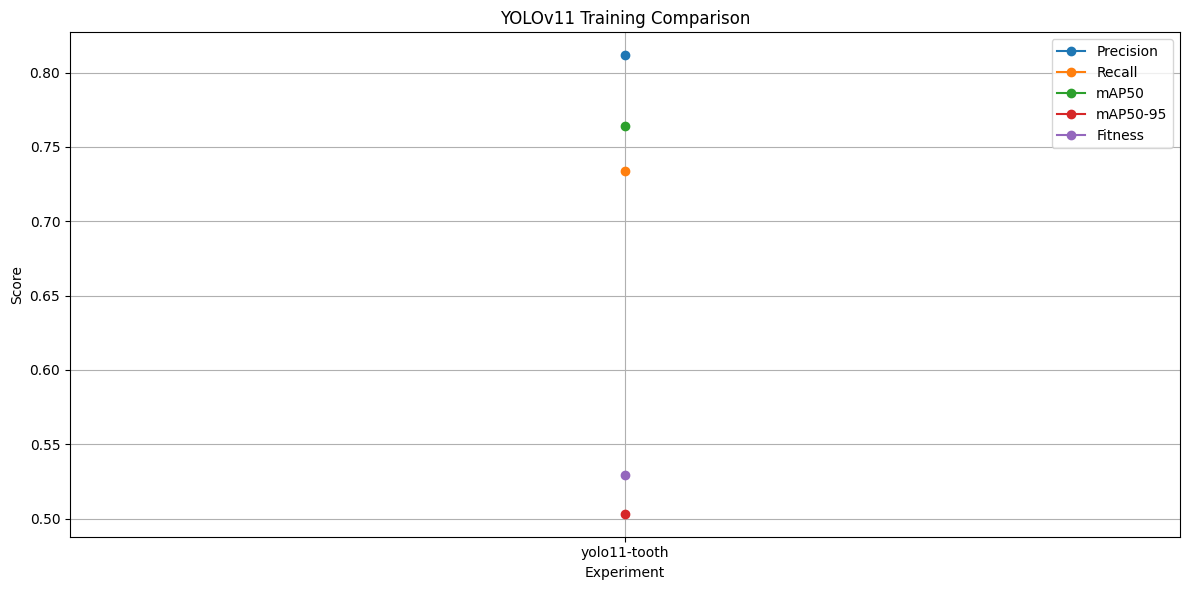

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Experiment performance data
data = {
    "Experiment": ["yolo11-tooth"],
    "Precision": [0.8117],
    "Recall": [0.7337],
    "mAP50": [0.7639],
    "mAP50-95": [0.5032],
    "Fitness": [0.5293]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Plotting each metric
metrics = ["Precision", "Recall", "mAP50", "mAP50-95", "Fitness"]

plt.figure(figsize=(12, 6))
for metric in metrics:
    plt.plot(df["Experiment"], df[metric], marker='o', label=metric)

# Title and labels for the graph
plt.title("YOLOv11 Training Comparison")
plt.xlabel("Experiment")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
import os

save_path = "/kaggle/working/saved_models"
os.makedirs(save_path, exist_ok=True)

try:
    model.save(os.path.join(save_path, "last_trained.pt"))
    print("Model saved successfully at:", os.path.join(save_path, "last_trained.pt"))
except Exception as e:
    print("Error while saving the model:", str(e))


Model saved successfully at: /kaggle/working/saved_models/last_trained.pt


In [7]:
results_dict = {
    'metrics/precision(B)': 0.8117,
    'metrics/recall(B)': 0.7337,
    'metrics/mAP50(B)': 0.7639,
    'metrics/mAP50-95(B)': 0.5032,
    'fitness': 0.5293
}

precision = results_dict['metrics/precision(B)']
recall = results_dict['metrics/recall(B)']
mAP50 = results_dict['metrics/mAP50(B)']
mAP5095 = results_dict['metrics/mAP50-95(B)']
fitness = results_dict['fitness']

metrics = {
    'Precision': precision,
    'Recall': recall,
    'mAP50': mAP50,
    'mAP50-95': mAP5095,
    'Fitness': fitness
}
print(" Training Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k:<10}: {v:.4f}")

 Training Evaluation Metrics:
Precision : 0.8117
Recall    : 0.7337
mAP50     : 0.7639
mAP50-95  : 0.5032
Fitness   : 0.5293



image 1/1 /kaggle/working/Tooth-instance-segmentation-2/test/images/134_jpg.rf.69ed22df47564e946d031b4d547f25f5.jpg: 384x640 4 Fillings, 10 Implants, 3 Root Canal Obturations, 45.1ms
Speed: 2.1ms preprocess, 45.1ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


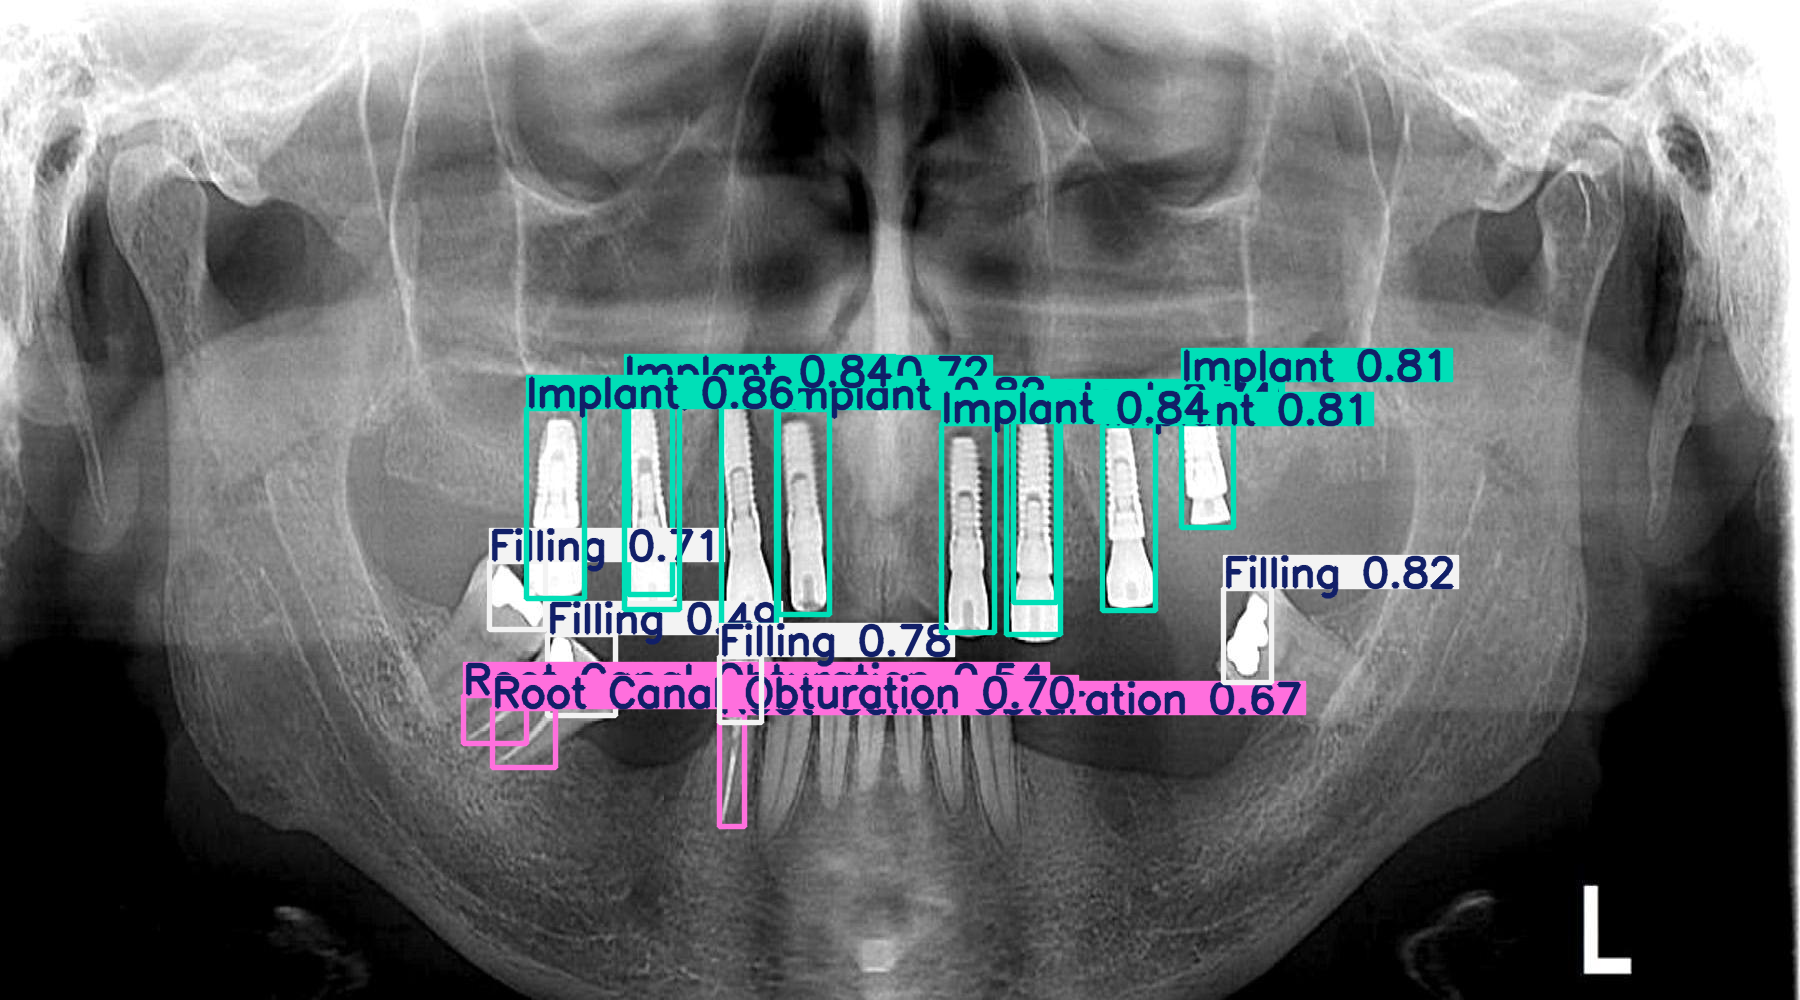

In [8]:
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Load the trained model
model = YOLO("/kaggle/working/saved_models/last_trained.pt")  # Path to the trained model

# Define the image path for testing the model
image_path = '/kaggle/working/Tooth-instance-segmentation-2/test/images/134_jpg.rf.69ed22df47564e946d031b4d547f25f5.jpg'  # Replace with the path to your image

# Use the model to make predictions on the image
results = model.predict(image_path)

# Access the first result in the list and display it
results[0].show()  # This will show the image with predicted bounding boxes

# If you want to save the results instead of displaying them
# results[0].save()  # Uncomment this to save the image with predictions


In [12]:
!pip install -q albumentations --upgrade


In [ ]:
import os
import cv2
import albumentations as A
from tqdm import tqdm
import numpy as np

# Paths
images_dir = "/kaggle/working/Tooth-instance-segmentation-2/train/images"
labels_dir = "/kaggle/working/Tooth-instance-segmentation-2/train/labels"
output_images_dir = "/kaggle/working/augmented/images"
output_labels_dir = "/kaggle/working/augmented/labels"

os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Classes to apply augmentation for
target_classes = {'Crown - bridge': 1, 'Post-screw': 4, 'Implant': 3}
target_class_ids = set(target_classes.values())

# Function to clip bbox coordinates to stay within [0, 1]
def clip_bboxes(bboxes):
    """Ensure that bbox coordinates are within the range [0, 1]."""
    for bbox in bboxes:
        bbox[0] = max(0, min(1, bbox[0]))  # x_min
        bbox[1] = max(0, min(1, bbox[1]))  # y_min
        bbox[2] = max(0, min(1, bbox[2]))  # x_max
        bbox[3] = max(0, min(1, bbox[3]))  # y_max
    return bboxes

def validate_bboxes(bboxes, image_width, image_height):
    """Normalize bbox coordinates based on image size and clip them to [0, 1]."""
    for i in range(len(bboxes)):
        bboxes[i][0] = max(0, min(1, bboxes[i][0] / image_width))   # x_min
        bboxes[i][1] = max(0, min(1, bboxes[i][1] / image_height))  # y_min
        bboxes[i][2] = max(0, min(1, bboxes[i][2] / image_width))   # x_max
        bboxes[i][3] = max(0, min(1, bboxes[i][3] / image_height))  # y_max
    return bboxes

# Ensure all bboxes contain only 4 coordinates
def check_bboxes(bboxes):
    """Check that each bbox has exactly 4 values."""
    valid_bboxes = []
    for bbox in bboxes:
        if len(bbox) == 4:
            valid_bboxes.append(bbox)
        else:
            print(f"Invalid bbox detected, skipping: {bbox}")
    return valid_bboxes

# Augmentation transformations
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Rotate(limit=20, p=0.5)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

# Function to read YOLO-formatted labels
def read_yolo_labels(label_path):
    bboxes = []
    class_ids = []
    if not os.path.exists(label_path):
        return [], []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            if class_id in target_class_ids:
                class_ids.append(class_id)
                bbox = list(map(float, parts[1:]))
                bboxes.append(bbox)
    return bboxes, class_ids

# Main loop for applying augmentation
aug_count = 0
for img_name in tqdm(os.listdir(images_dir)):
    img_path = os.path.join(images_dir, img_name)
    label_path = os.path.join(labels_dir, os.path.splitext(img_name)[0] + ".txt")

    image = cv2.imread(img_path)
    if image is None:
        continue
    height, width = image.shape[:2]
    bboxes, class_ids = read_yolo_labels(label_path)
    if not bboxes:
        continue

    # Validate bbox coordinates with respect to image size
    bboxes = validate_bboxes(bboxes, width, height)

    # Ensure all bboxes have valid shape
    bboxes = check_bboxes(bboxes)

    # Apply augmentation
    augmented = transform(image=image, bboxes=bboxes, class_labels=class_ids)
    aug_img = augmented['image']
    aug_bboxes = augmented['bboxes']
    aug_labels = augmented['class_labels']

    # Clip bbox coordinates after augmentation
    aug_bboxes = clip_bboxes(aug_bboxes)

    new_img_name = os.path.splitext(img_name)[0] + f"_aug{aug_count}.jpg"
    new_img_path = os.path.join(output_images_dir, new_img_name)
    cv2.imwrite(new_img_path, aug_img)

    new_label_path = os.path.join(output_labels_dir, os.path.splitext(new_img_name)[0] + ".txt")
    with open(new_label_path, 'w') as f:
        for class_id, bbox in zip(aug_labels, aug_bboxes):
            f.write(f"{class_id} {' '.join(map(str, bbox))}\n")

    aug_count += 1

print(f"Augmented {aug_count} images")


Labels for /kaggle/working/augmented/images/104_jpg.rf.7a93ea88cdf6dc25060160a675f5635a_aug1750.jpg:
Class IDs: []
Bounding Boxes: []


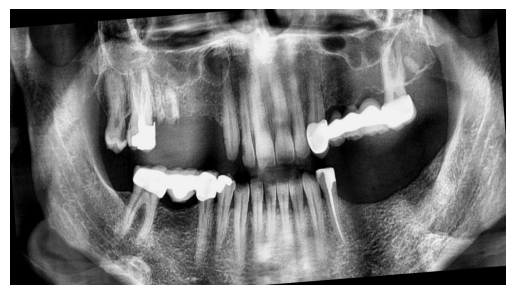

Labels for /kaggle/working/augmented/images/d27f3b92-Jalilvand_Mohammad_67yo_31052021_183733_jpg.rf.0a92d2193d59d2e0a40d8fd206be0723_aug1089.jpg:
Class IDs: []
Bounding Boxes: []


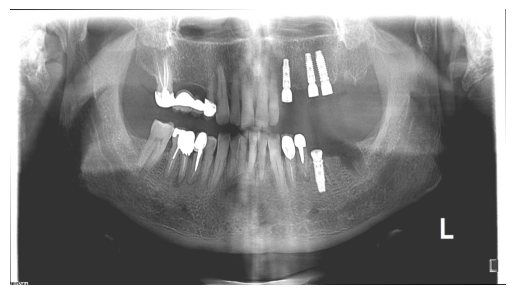

In [ ]:
import cv2
import matplotlib.pyplot as plt
import os

# Paths to images and labels
images_dir = "/kaggle/working/augmented/images"
labels_dir = "/kaggle/working/augmented/labels"

# Function to read YOLO labels
def read_yolo_labels(label_path):
    bboxes = []
    class_ids = []
    if not os.path.exists(label_path):
        return [], []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            bboxes.append(bbox)
            class_ids.append(class_id)
    return bboxes, class_ids

# Function to display an image with bounding boxes
def show_image_with_bboxes(image_path, label_path):
    image = cv2.imread(image_path)
    bboxes, class_ids = read_yolo_labels(label_path)

    # Print the labels
    print(f"Labels for {image_path}:")
    print(f"Class IDs: {class_ids}")
    print(f"Bounding Boxes: {bboxes}")
    
    # Convert the image from BGR to RGB for matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the bounding boxes
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        # Convert normalized coordinates [0, 1] to pixel values
        x_min, y_min, x_max, y_max = int(x_min * image.shape[1]), int(y_min * image.shape[0]), int(x_max * image.shape[1]), int(y_max * image.shape[0])
        # Draw a rectangle around the bbox
        cv2.rectangle(image_rgb, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

    # Show the image
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

# Test on two images
image1_name = os.listdir(images_dir)[0]
image1_path = os.path.join(images_dir, image1_name)
label1_path = os.path.join(labels_dir, os.path.splitext(image1_name)[0] + ".txt")

image2_name = os.listdir(images_dir)[1]
image2_path = os.path.join(images_dir, image2_name)
label2_path = os.path.join(labels_dir, os.path.splitext(image2_name)[0] + ".txt")

# Display the two images with bounding boxes
show_image_with_bboxes(image1_path, label1_path)
show_image_with_bboxes(image2_path, label2_path)


In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="jblXI5MTWDuIfBMWytfI")
project = rf.workspace("khaled-hjb0q").project("tooth-instance-segmentation-vrbtu")
dataset = project.version(1).download("yolov11")


loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to Tooth-instance-segmentation-1 in yolov11:: 100%|██████████| 12500/12500 [00:01<00:00, 6309.95it/s]


In [12]:
print("Train Images:", len(os.listdir(train_images)))
print("Train Labels:", len(os.listdir(train_labels)))

print("Val Images:", len(os.listdir(val_images)))
print("Val Labels:", len(os.listdir(val_labels)))

print("Test Images:", len(os.listdir(test_images)))
print("Test Labels:", len(os.listdir(test_labels)))

Train Images: 5144
Train Labels: 5144
Val Images: 729
Val Labels: 729
Test Images: 371
Test Labels: 371


In [22]:
import os

def remove_classes_from_labels(label_dir, remove_ids):
    removed = 0
    for label_file in os.listdir(label_dir):
        path = os.path.join(label_dir, label_file)
        with open(path, 'r') as f:
            lines = f.readlines()
        
        # احتفظ فقط بالأسطر اللي مش بتحتوي على الكلاسات المحذوفة
        new_lines = [line for line in lines if int(line.split()[0]) not in remove_ids]
        
        if len(lines) != len(new_lines):
            removed += 1
        
        # اكتب الملف بعد التنضيف
        with open(path, 'w') as f:
            f.writelines(new_lines)
    
    print(f"Cleaned {removed} label files from unwanted classes.")


train_labels = "/kaggle/working/Tooth-instance-segmentation-1/train/labels"
val_labels = "/kaggle/working/Tooth-instance-segmentation-1/valid/labels"
test_labels = "/kaggle/working/Tooth-instance-segmentation-1/test/labels"


remove_ids = [1, 5]


remove_classes_from_labels(train_labels, remove_ids)
remove_classes_from_labels(val_labels, remove_ids)
remove_classes_from_labels(test_labels, remove_ids)


Cleaned 222 label files from unwanted classes.
Cleaned 29 label files from unwanted classes.
Cleaned 16 label files from unwanted classes.


In [23]:
import yaml

yaml_path = "/kaggle/working/Tooth-instance-segmentation-1/data.yaml"

with open(yaml_path, 'r') as f:
    data = yaml.safe_load(f)

# delete the selected classes
original_names = data['names']
new_names = [name for i, name in enumerate(original_names) if i not in remove_ids]

# update data
data['names'] = new_names
data['nc'] = len(new_names)

# save edits
with open(yaml_path, 'w') as f:
    yaml.dump(data, f)

print(" data.yaml updated successfully.")


 data.yaml updated successfully.


In [25]:
import yaml

# new paths
data = {
    'train': '/kaggle/working/Tooth-instance-segmentation-1/train/images',
    'val': '/kaggle/working/Tooth-instance-segmentation-1/valid/images',
    'test': '/kaggle/working/Tooth-instance-segmentation-1/test/images',
    'nc': 6,
    'names': ['Caries', 'Crown - bridge', 'Filling', 'Implant', 'Post-screw', 'Root Canal Obturation']
}

# save file
with open('/kaggle/working/Tooth-instance-segmentation-1/data.yaml', 'w') as file:
    yaml.dump(data, file)

print("data.yaml updated")


data.yaml updated


In [27]:
import os

# Define old → new class ID mapping
id_mapping = {
    0: 0,  # Caries
    2: 1,  # Crown - bridge
    3: 2,  # Filling
    4: 3,  # Implant
    6: 4,  # Post-screw
    7: 5   # Root Canal Obturation
}

def remap_class_ids(label_dir, id_mapping):
    updated_files = 0
    for label_file in os.listdir(label_dir):
        full_path = os.path.join(label_dir, label_file)
        with open(full_path, 'r') as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            if line.strip():
                old_id = int(line.split()[0])
                if old_id in id_mapping:
                    new_id = id_mapping[old_id]
                    rest = ' '.join(line.strip().split()[1:])
                    new_lines.append(f"{new_id} {rest}\n")

        with open(full_path, 'w') as f:
            f.writelines(new_lines)
        
        updated_files += 1
    print(f"✅ Updated {updated_files} label files in {label_dir}")

# Paths
train_labels = "/kaggle/working/Tooth-instance-segmentation-1/train/labels"
val_labels = "/kaggle/working/Tooth-instance-segmentation-1/valid/labels"
test_labels = "/kaggle/working/Tooth-instance-segmentation-1/test/labels"

# Apply mapping
remap_class_ids(train_labels, id_mapping)
remap_class_ids(val_labels, id_mapping)
remap_class_ids(test_labels, id_mapping)


✅ Updated 5144 label files in /kaggle/working/Tooth-instance-segmentation-1/train/labels
✅ Updated 729 label files in /kaggle/working/Tooth-instance-segmentation-1/valid/labels
✅ Updated 371 label files in /kaggle/working/Tooth-instance-segmentation-1/test/labels


Found class IDs in dataset: dict_keys([3, 0, 6, 7, 2, 4])
Length of class_names: 8
Number of instances per class in train set:
Filling: 35652
Caries: 19422
Post-screw: 2962
Root Canal Obturation: 22414
Crown - bridge: 6272
Implant: 984


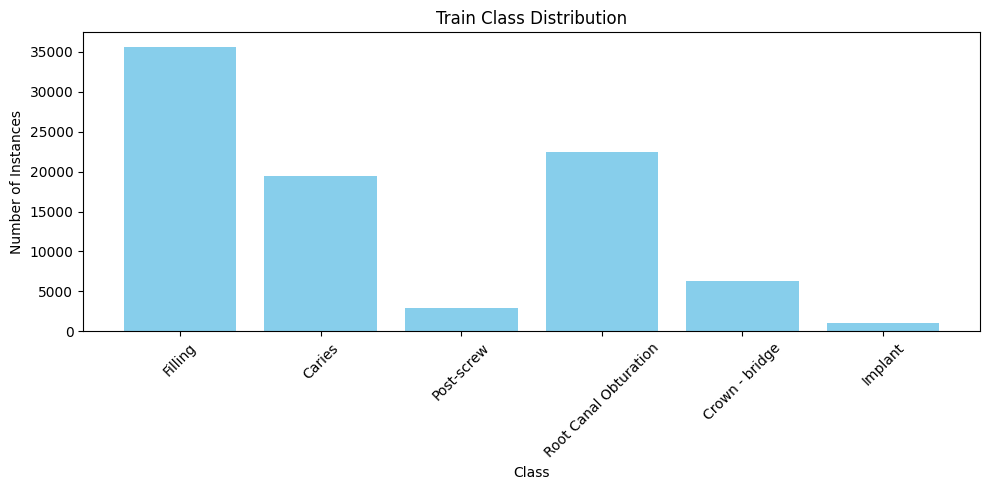

In [26]:
import os
from collections import Counter
import matplotlib.pyplot as plt

def count_labels(label_dir, class_names):
    class_counts = Counter()

    for label_file in os.listdir(label_dir):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():
                    cls_id = int(line.strip().split()[0])
                    class_counts[cls_id] += 1

    print("Found class IDs in dataset:", class_counts.keys())
    print("Length of class_names:", len(class_names))

    # Convert class IDs to class names safely
    result = {
        class_names[k]: v for k, v in class_counts.items() if k < len(class_names)
    }
    return result

# Define path to labels in Tooth-instance-segmentation
train_labels = "/kaggle/working/Tooth-instance-segmentation-1/train/labels"

# Define class names based on order in Roboflow config
class_names = [
    'Caries',
    'Crown',
    'Crown - bridge',
    'Filling',
    'Implant',
    'Periapical lesion',
    'Post-screw',
    'Root Canal Obturation'
]


# Analyze label distribution
train_class_distribution = count_labels(train_labels, class_names)

# Print results
print("Number of instances per class in train set:")
for k, v in train_class_distribution.items():
    print(f"{k}: {v}")

# Plot
plt.figure(figsize=(10, 5))
plt.bar(train_class_distribution.keys(), train_class_distribution.values(), color='skyblue')
plt.xticks(rotation=45)
plt.title("Train Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Instances")
plt.tight_layout()
plt.show()


# Fine Tuning

In [1]:
import torch
torch.cuda.empty_cache()

from ultralytics import YOLO

model = YOLO("/kaggle/input/best-pt/best.pt")

model.train(
    data="/kaggle/working/Tooth-instance-segmentation-1/data.yaml",  
    epochs=70,                    
    imgsz=640,                    
    batch=16,                     
    lr0=0.01,                     
    optimizer='SGD',
    momentum=0.937,
    weight_decay=0.0005,
    name="yolo11-tooth2-ftuned", 
    pretrained=True,             
    iou=0.5                       
)


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/Tooth-instance-segmentation-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=70, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.5, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/kaggle/input/best-pt/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11-tooth2-ftuned3, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, pat

train: Scanning /kaggle/working/Tooth-instance-segmentation-1/train/labels... 5144 images, 10 backgrounds, 0 corrupt: 100%|██████████| 5144/5144 [00:06<00:00, 834.01it/s]


train: New cache created: /kaggle/working/Tooth-instance-segmentation-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 710.2±325.0 MB/s, size: 58.1 KB)


val: Scanning /kaggle/working/Tooth-instance-segmentation-1/valid/labels... 729 images, 1 backgrounds, 0 corrupt: 100%|██████████| 729/729 [00:01<00:00, 689.51it/s]

val: New cache created: /kaggle/working/Tooth-instance-segmentation-1/valid/labels.cache


Plotting labels to runs/detect/yolo11-tooth2-ftuned3/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11-tooth2-ftuned3
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      2.78G       1.52     0.9491       1.11        300        640: 100%|██████████| 322/322 [01:28<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:07<00:00,  3.20it/s]

                   all        729      12493      0.613      0.526      0.524      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      2.79G      1.488     0.9289      1.091        177        640: 100%|██████████| 322/322 [01:25<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.20it/s]


                   all        729      12493      0.701      0.645      0.647      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      2.79G       1.53     0.9519      1.099        256        640: 100%|██████████| 322/322 [01:25<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


                   all        729      12493      0.654      0.543       0.55       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      2.79G      1.535     0.9513      1.096        254        640: 100%|██████████| 322/322 [01:26<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.32it/s]


                   all        729      12493      0.696      0.636      0.651      0.362

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      2.79G      1.488      0.921      1.081        191        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]


                   all        729      12493      0.711      0.688      0.698      0.387

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      2.79G      1.473     0.9107      1.075        205        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


                   all        729      12493      0.728      0.697      0.713      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      2.79G      1.438     0.8897      1.063        165        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.19it/s]


                   all        729      12493      0.722      0.685      0.691      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      2.79G      1.432     0.8813       1.06        192        640: 100%|██████████| 322/322 [01:24<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.33it/s]


                   all        729      12493      0.761      0.707      0.724      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      2.79G      1.405     0.8649      1.056        209        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


                   all        729      12493      0.773      0.718      0.737      0.437

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      2.79G      1.396     0.8603      1.045        209        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.33it/s]


                   all        729      12493      0.763      0.717      0.737      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      2.79G      1.389     0.8517      1.045        203        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.30it/s]


                   all        729      12493      0.769      0.726      0.737      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      2.79G      1.368     0.8425      1.042        195        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.11it/s]


                   all        729      12493      0.766      0.711      0.733      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      2.79G      1.366      0.837      1.038        136        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


                   all        729      12493      0.771      0.702      0.731      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      2.79G      1.348     0.8272      1.034        138        640: 100%|██████████| 322/322 [01:25<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]


                   all        729      12493        0.8       0.72      0.756       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      2.79G      1.339     0.8216      1.029        155        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


                   all        729      12493      0.785      0.741      0.751      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      2.79G       1.32     0.8079      1.024        164        640: 100%|██████████| 322/322 [01:25<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


                   all        729      12493      0.789       0.75      0.763      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      2.79G      1.309     0.8008      1.022        128        640: 100%|██████████| 322/322 [01:23<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.09it/s]


                   all        729      12493      0.784      0.741      0.754      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      2.79G      1.311     0.7985      1.023        233        640: 100%|██████████| 322/322 [01:23<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.40it/s]


                   all        729      12493       0.79      0.742      0.767      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      2.79G      1.306     0.7957      1.021        226        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.28it/s]


                   all        729      12493      0.804      0.739      0.768      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      2.79G      1.302     0.7891      1.012        260        640: 100%|██████████| 322/322 [01:24<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.32it/s]


                   all        729      12493      0.808       0.75      0.773       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      2.79G      1.294     0.7848      1.016        217        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.34it/s]


                   all        729      12493      0.786      0.741      0.761      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      2.79G      1.278     0.7796      1.015        115        640: 100%|██████████| 322/322 [01:24<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.30it/s]


                   all        729      12493      0.798      0.749       0.77      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      2.79G      1.271     0.7714      1.011        120        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]


                   all        729      12493      0.816      0.755      0.779      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      2.79G      1.271     0.7708      1.005        190        640: 100%|██████████| 322/322 [01:23<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


                   all        729      12493      0.815      0.746      0.776      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      2.79G      1.254     0.7622      1.004        223        640: 100%|██████████| 322/322 [01:23<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.43it/s]


                   all        729      12493      0.809      0.748      0.774      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      2.79G      1.257     0.7597      1.005        153        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]


                   all        729      12493      0.815      0.757      0.782      0.494

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      2.79G      1.251     0.7555      1.002        242        640: 100%|██████████| 322/322 [01:23<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


                   all        729      12493      0.805      0.752      0.783      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      2.79G      1.236     0.7456     0.9967        161        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]


                   all        729      12493      0.818      0.757      0.782      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      2.79G      1.237     0.7465     0.9947        154        640: 100%|██████████| 322/322 [01:24<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.45it/s]


                   all        729      12493      0.816      0.761      0.787      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      2.79G       1.24     0.7472      0.997        159        640: 100%|██████████| 322/322 [01:23<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


                   all        729      12493      0.824      0.754      0.788      0.499

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      2.79G      1.217      0.735     0.9937        218        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.29it/s]


                   all        729      12493      0.809      0.769      0.792       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      2.79G       1.22     0.7395     0.9913        221        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.45it/s]


                   all        729      12493      0.806      0.776      0.785      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      2.79G      1.213     0.7321     0.9887         77        640: 100%|██████████| 322/322 [01:24<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


                   all        729      12493       0.82      0.768      0.793      0.506

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      2.79G      1.207     0.7257     0.9852        190        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


                   all        729      12493      0.823      0.772      0.795      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      2.79G      1.204     0.7247     0.9837        105        640: 100%|██████████| 322/322 [01:24<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.14it/s]


                   all        729      12493      0.828      0.773      0.803       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      2.79G      1.195     0.7186     0.9809        243        640: 100%|██████████| 322/322 [01:24<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


                   all        729      12493      0.839      0.769      0.805      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      2.79G       1.19     0.7132     0.9797        232        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


                   all        729      12493      0.827      0.775      0.801      0.521

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      2.79G      1.187     0.7088     0.9788        147        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.30it/s]


                   all        729      12493      0.839       0.78      0.809       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      2.79G      1.196     0.7109     0.9791        144        640: 100%|██████████| 322/322 [01:25<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.40it/s]


                   all        729      12493      0.839      0.766      0.804      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      2.79G      1.174     0.7036     0.9758        298        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.18it/s]


                   all        729      12493       0.83      0.779      0.809      0.531

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      2.79G       1.17     0.6999     0.9732        233        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.44it/s]


                   all        729      12493      0.839      0.775      0.807      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      2.79G      1.164     0.6969     0.9731        128        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


                   all        729      12493      0.834      0.786      0.813      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      2.79G      1.162     0.6961     0.9721        256        640: 100%|██████████| 322/322 [01:23<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


                   all        729      12493      0.838      0.776      0.812      0.529

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      2.79G      1.161     0.6895     0.9693        164        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.46it/s]


                   all        729      12493      0.848      0.783      0.815      0.537

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      2.79G       1.16     0.6945      0.971        207        640: 100%|██████████| 322/322 [01:23<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.45it/s]


                   all        729      12493      0.863      0.783      0.818      0.538

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      2.79G      1.155     0.6894     0.9698        120        640: 100%|██████████| 322/322 [01:26<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


                   all        729      12493      0.847      0.778      0.814      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      2.79G      1.152     0.6858     0.9677        275        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]


                   all        729      12493      0.842       0.79       0.82      0.541

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      2.79G      1.143     0.6805     0.9674        204        640: 100%|██████████| 322/322 [01:24<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.36it/s]


                   all        729      12493      0.834      0.797      0.821      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      2.79G      1.137     0.6766     0.9614        144        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.01it/s]


                   all        729      12493      0.835      0.794       0.82      0.546

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      2.79G      1.131     0.6755     0.9632        233        640: 100%|██████████| 322/322 [01:23<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


                   all        729      12493      0.837      0.792       0.82      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      2.79G      1.123      0.665     0.9602        182        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.42it/s]


                   all        729      12493       0.84        0.8      0.825      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      2.79G      1.121     0.6659     0.9599        212        640: 100%|██████████| 322/322 [01:25<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


                   all        729      12493      0.843      0.795      0.822      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      2.79G      1.119     0.6638     0.9592        228        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.39it/s]


                   all        729      12493      0.852      0.791      0.824       0.55

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      2.79G      1.113     0.6624     0.9561        166        640: 100%|██████████| 322/322 [01:24<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.12it/s]


                   all        729      12493      0.838      0.797      0.822      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      2.79G       1.11     0.6591     0.9546        232        640: 100%|██████████| 322/322 [01:23<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.47it/s]


                   all        729      12493      0.847      0.796      0.823      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      2.79G      1.101     0.6563     0.9564        180        640: 100%|██████████| 322/322 [01:29<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.41it/s]


                   all        729      12493      0.841      0.802      0.827      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      2.79G      1.099     0.6522     0.9528        233        640: 100%|██████████| 322/322 [01:24<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.26it/s]


                   all        729      12493      0.845      0.795      0.824      0.555

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      2.79G      1.092     0.6477     0.9488        159        640: 100%|██████████| 322/322 [01:25<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.40it/s]


                   all        729      12493      0.856        0.8      0.827      0.561

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      2.79G      1.099     0.6544     0.9529        248        640: 100%|██████████| 322/322 [01:24<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.38it/s]


                   all        729      12493      0.841      0.795      0.824      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      2.79G      1.096     0.6496     0.9498        201        640: 100%|██████████| 322/322 [01:24<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.27it/s]

                   all        729      12493      0.849      0.811      0.834      0.562


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      2.79G      1.043     0.6231     0.9736        125        640: 100%|██████████| 322/322 [00:59<00:00,  5.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.29it/s]


                   all        729      12493      0.853      0.798      0.827      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      2.79G      1.032     0.6123     0.9666        105        640: 100%|██████████| 322/322 [00:57<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.37it/s]


                   all        729      12493      0.854      0.804      0.833      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      2.79G      1.015     0.6035     0.9608        135        640: 100%|██████████| 322/322 [00:58<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]

                   all        729      12493      0.862      0.803      0.834      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      2.79G      1.018     0.6057     0.9635         85        640: 100%|██████████| 322/322 [00:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.49it/s]


                   all        729      12493      0.861      0.806      0.838      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      2.79G      1.005      0.599     0.9574        126        640: 100%|██████████| 322/322 [00:59<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.53it/s]


                   all        729      12493      0.856      0.811      0.839      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      2.79G     0.9992     0.5949     0.9558        139        640: 100%|██████████| 322/322 [00:58<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.66it/s]


                   all        729      12493      0.864      0.802      0.835      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      2.79G     0.9993     0.5959     0.9542        101        640: 100%|██████████| 322/322 [00:58<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.56it/s]


                   all        729      12493      0.861      0.808      0.839      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      2.79G      0.992      0.592     0.9541        105        640: 100%|██████████| 322/322 [00:58<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:04<00:00,  4.63it/s]


                   all        729      12493      0.862      0.808       0.84      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      2.79G     0.9854     0.5887     0.9544        158        640: 100%|██████████| 322/322 [00:58<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.48it/s]


                   all        729      12493      0.866      0.806       0.84      0.579

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      2.79G      0.986     0.5873     0.9527        101        640: 100%|██████████| 322/322 [00:58<00:00,  5.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:05<00:00,  4.54it/s]


                   all        729      12493      0.864      0.808      0.842      0.581

70 epochs completed in 1.683 hours.
Optimizer stripped from runs/detect/yolo11-tooth2-ftuned3/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11-tooth2-ftuned3/weights/best.pt, 5.5MB

Validating runs/detect/yolo11-tooth2-ftuned3/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11 summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:09<00:00,  2.47it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        729      12493      0.863      0.809      0.842      0.581
                Caries        495       2794      0.759       0.46      0.569      0.259
        Crown - bridge        291        971      0.925      0.989      0.987      0.805
               Filling        660       4998       0.94      0.942      0.969      0.783
               Implant         44        140      0.978      0.964      0.971      0.772
            Post-screw        230        479       0.75      0.678      0.704      0.338
 Root Canal Obturation        550       3111      0.829      0.821       0.85      0.527
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/yolo11-tooth2-ftuned3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3d5a933b10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [5]:
metrics = model.val()


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11 summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1677.5±388.1 MB/s, size: 56.8 KB)


val: Scanning /kaggle/working/Tooth-instance-segmentation-1/valid/labels.cache... 729 images, 1 backgrounds, 0 corrupt: 100%|██████████| 729/729 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 46/46 [00:09<00:00,  4.70it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        729      12493      0.862      0.807       0.84      0.583
                Caries        495       2794      0.759      0.458      0.569      0.259
        Crown - bridge        291        971      0.924      0.989      0.987      0.807
               Filling        660       4998       0.94      0.942      0.969      0.787
               Implant         44        140      0.978      0.964      0.971      0.775
            Post-screw        230        479      0.742      0.668      0.695      0.339
 Root Canal Obturation        550       3111       0.83      0.819      0.851      0.532
Speed: 0.6ms preprocess, 4.4ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/yolo11-tooth2-ftuned32


In [3]:
results_dict = {
    'metrics/precision(B)': 0.8634,
    'metrics/recall(B)': 0.8090,
    'metrics/mAP50(B)': 0.8416,
    'metrics/mAP50-95(B)': 0.5808,
    'fitness': 0.6069
}

precision = results_dict['metrics/precision(B)']
recall = results_dict['metrics/recall(B)']
mAP50 = results_dict['metrics/mAP50(B)']
mAP5095 = results_dict['metrics/mAP50-95(B)']
fitness = results_dict['fitness']

metrics = {
    'Precision': precision,
    'Recall': recall,
    'mAP50': mAP50,
    'mAP50-95': mAP5095,
    'Fitness': fitness
}
print(" Training Evaluation Metrics:")
for k, v in metrics.items():
    print(f"{k:<10}: {v:.4f}")

 Training Evaluation Metrics:
Precision : 0.8634
Recall    : 0.8090
mAP50     : 0.8416
mAP50-95  : 0.5808
Fitness   : 0.6069


In [4]:
import os

save_path = "/kaggle/working/saved_models"
os.makedirs(save_path, exist_ok=True)

try:
    model.save(os.path.join(save_path, "last_trained.pt"))
    print("Model saved successfully at:", os.path.join(save_path, "last_trained.pt"))
except Exception as e:
    print("Error while saving the model:", str(e))


Model saved successfully at: /kaggle/working/saved_models/last_trained.pt



0: 640x640 6 Fillings, 13 Root Canal Obturations, 11.1ms
Speed: 1.7ms preprocess, 11.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 15 Fillings, 1 Post-screw, 10 Root Canal Obturations, 8.1ms
Speed: 1.4ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


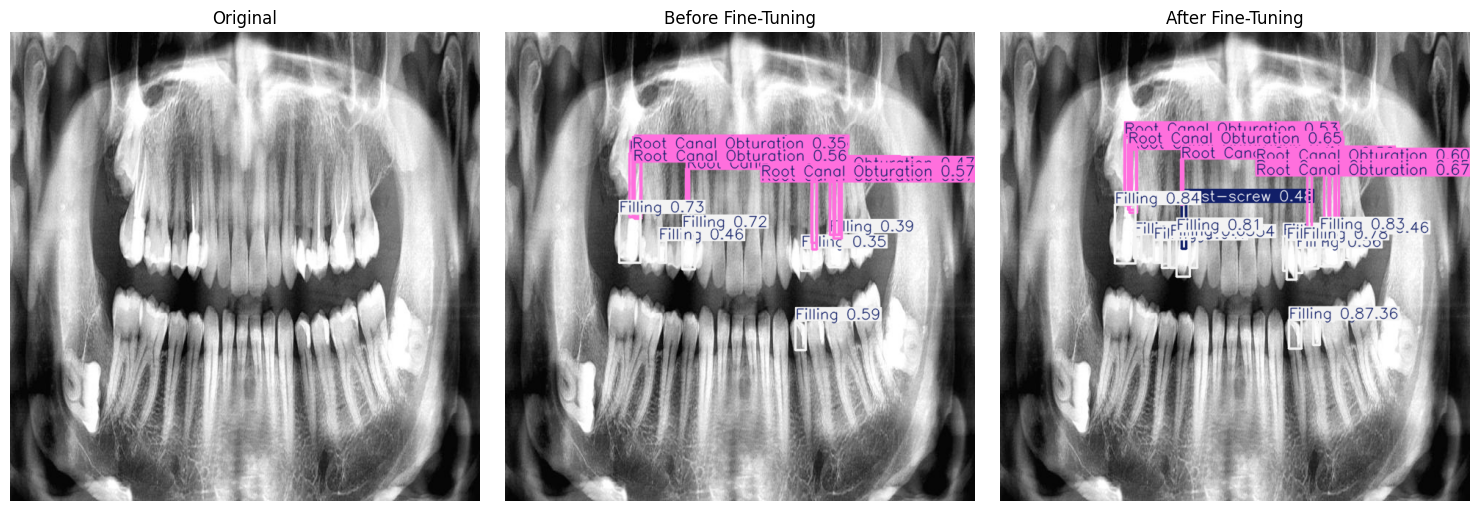


0: 640x640 13 Fillings, 2 Post-screws, 3 Root Canal Obturations, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Caries, 15 Fillings, 3 Post-screws, 3 Root Canal Obturations, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


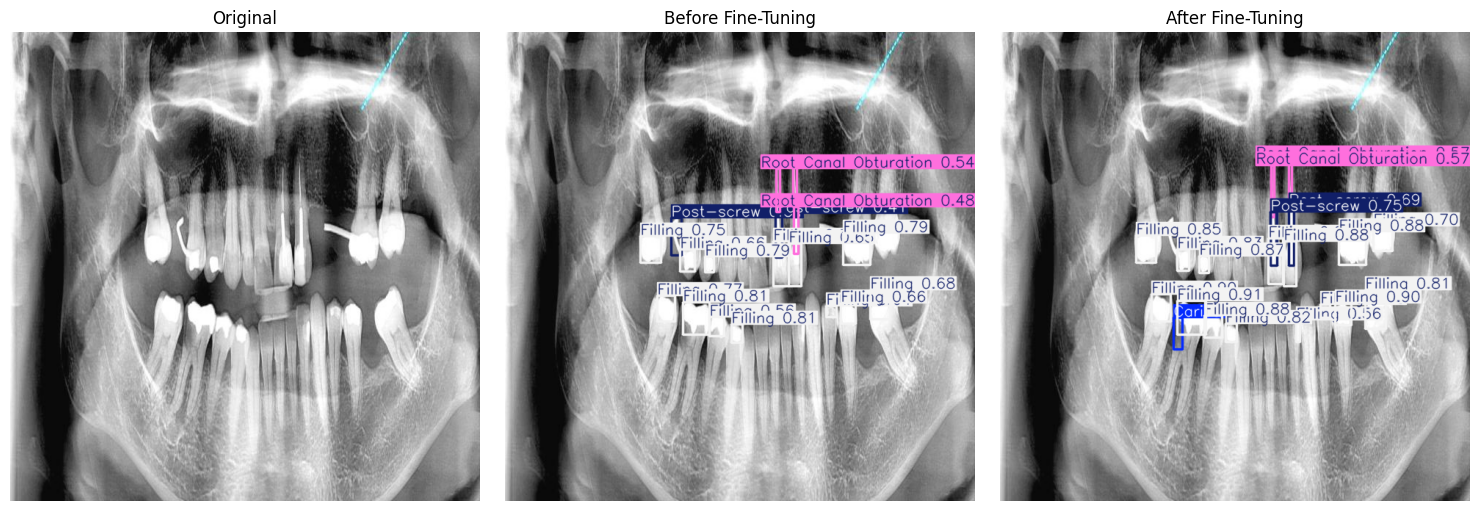


0: 640x640 10 Fillings, 1 Post-screw, 15 Root Canal Obturations, 9.5ms
Speed: 1.5ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 14 Fillings, 9 Root Canal Obturations, 8.0ms
Speed: 1.3ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


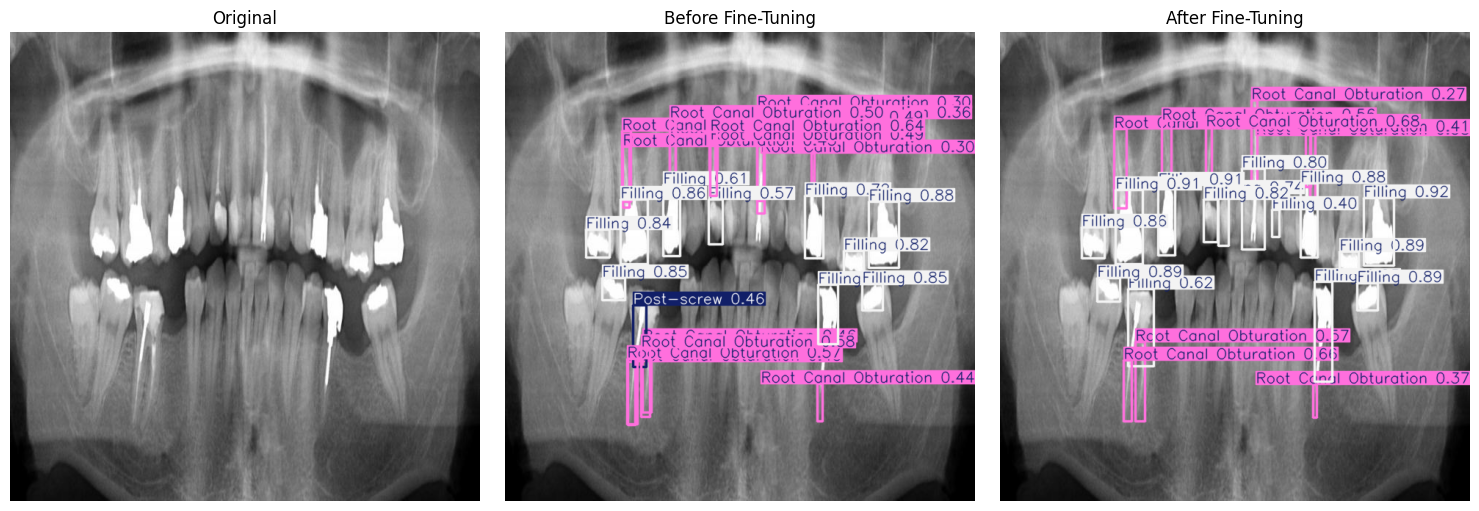


0: 640x640 1 Filling, 1 Root Canal Obturation, 9.2ms
Speed: 1.4ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Caries, 1 Filling, 2 Root Canal Obturations, 8.2ms
Speed: 1.3ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


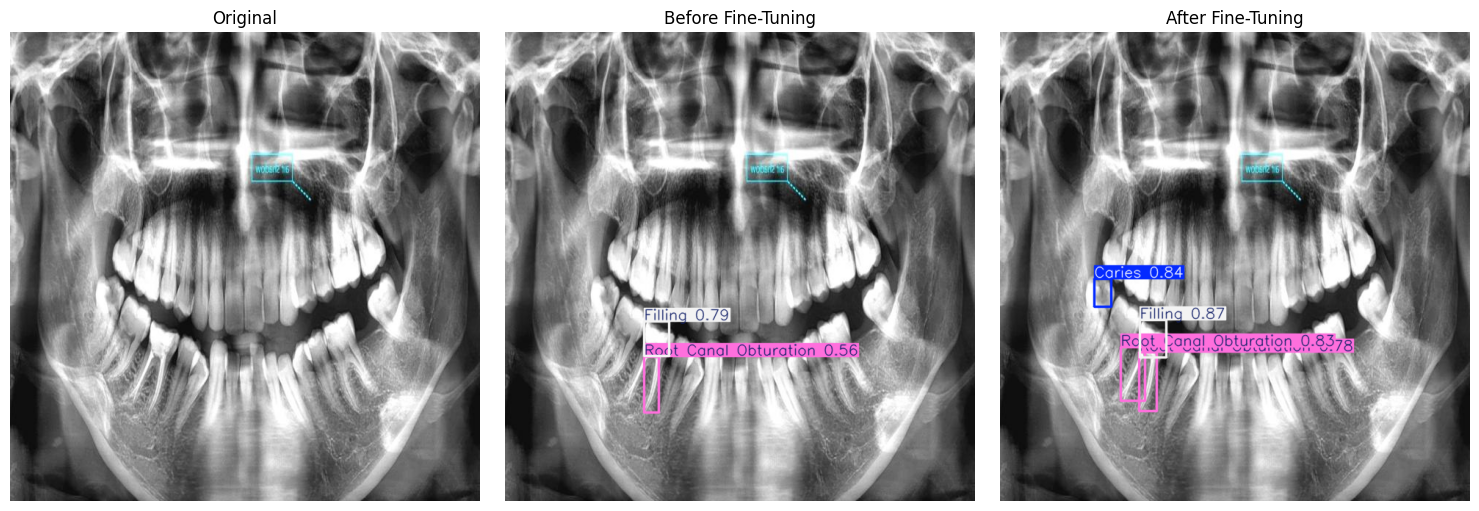


0: 640x640 19 Fillings, 9 Root Canal Obturations, 9.2ms
Speed: 1.5ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Crown - bridge, 16 Fillings, 6 Root Canal Obturations, 8.4ms
Speed: 1.4ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


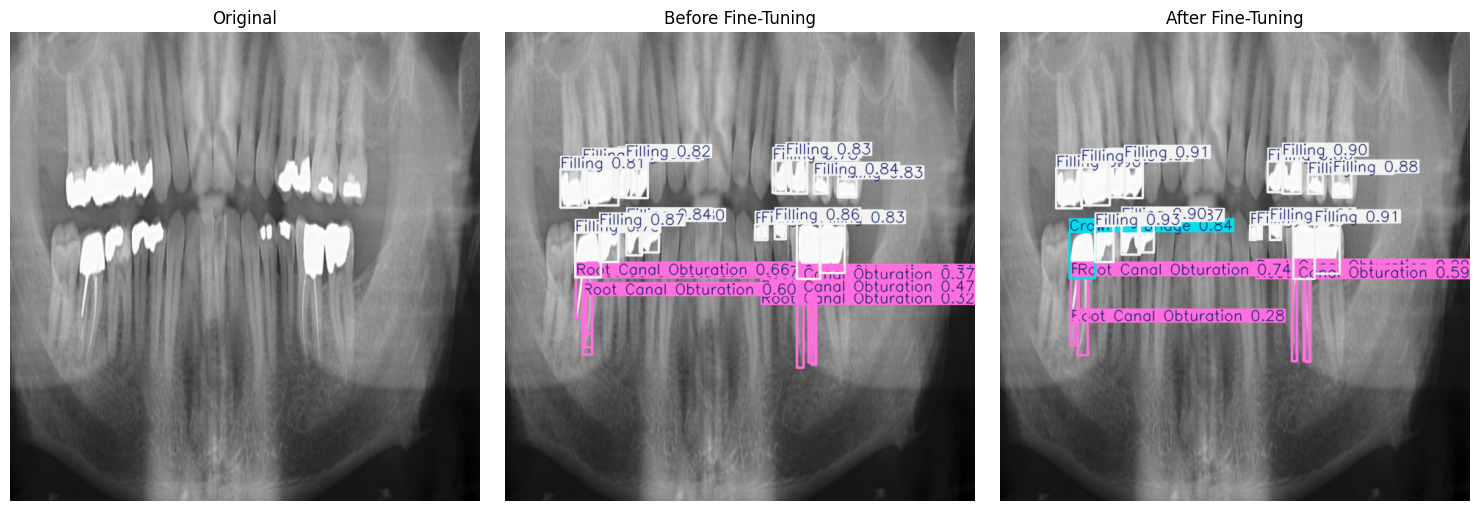

In [16]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image

# Load both models
model_old = YOLO("/kaggle/input/best-pt/best.pt")  # before fine-tuning
model_new = YOLO("/kaggle/working/runs/detect/yolo11-tooth2-ftuned3/weights/best.pt")  # after fine-tuning

# Path to sample images from validation set
val_images_path = "/kaggle/working/Tooth-instance-segmentation-1/valid/images"
sample_imgs = os.listdir(val_images_path)[:5]  # Take first 5 images for example

# Plotting function
def show_comparison(img_path):
    image = Image.open(img_path).convert("RGB")

    # Predictions
    pred_old = model_old.predict(image, conf=0.25)[0].plot()
    pred_new = model_new.predict(image, conf=0.25)[0].plot()

    # Convert for plotting
    img_orig = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    pred_old = cv2.cvtColor(pred_old, cv2.COLOR_BGR2RGB)
    pred_new = cv2.cvtColor(pred_new, cv2.COLOR_BGR2RGB)

    # Show images
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img_orig)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(pred_old)
    plt.title("Before Fine-Tuning")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_new)
    plt.title("After Fine-Tuning")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Compare all selected images
for img in sample_imgs:
    img_path = os.path.join(val_images_path, img)
    show_comparison(img_path)
